# Feature Extraction and Text Similarity: Finding Related Wikipedia Articles

## Motivation
I'm currently enrolled in a four-course [Machine Learning Specialization](https://www.coursera.org/specializations/machine-learning) offered through Coursera and taught by researchers at the University of Washington. So far I've found the classes and assignments to be worthwile and well-organized. While the courses teach machine learning algorithms and concepts in a way that is agnostic of any particular programming language or package, the specific tools are ultimately implemented using the ```Graphlab``` library in Python. So far, ```Graphlab``` seems to be pretty easy to use, and it also has the really nice advantage of being able to scale out-of-core (rather than execute implementations completely in memory). However, unlike the other popular machine learning library in Python, ```sckit-learn```, ```Graphlab``` is a commerical software. If effort to stay with open-source tools, I've been completing the assignments using both ```scikit-learn``` and ```Graphlab```. 

## Introduction

In the following post, I demonstrate how feature extraction and k-nearest neighbor algorithms can be used to compare the similarity of the text in Wikipedia articles, ultimately to find articles that are closely related to one another. 


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
%matplotlib inline

First, I read in a CSV file that contains the name of famous people and their corresponding Wikipedia article text. There are 53,164 people in this dataset.

In [3]:
wiki_data = pd.read_csv('wiki_people.csv', index_col='name')['text']
print len(wiki_data)
print 
print wiki_data.head()

53164

name
Mark Spencer (politician)    mark steven spencer born 20 january 1970is an ...
Madison U. Sowell            madison u sowell is the provost at southern vi...
Harry B. Luthi               harry b luthi sr born 1933 is a retired busine...
Abou Diaby                   vassiriki abou diaby french pronunciation abu ...
Roger Sedarat                roger sedarat is an iranianamerican poet he is...
Name: text, dtype: object


## Feature Extraction from Text Documents

### Word Count Vectors

One way to represent a text document is to count the instances of every word in the document. Then articles can be compared based on how similar their word count vectors are. Below, I use the ```CountVectorizer``` in `scikit-learn` to generate a vector of word counts for the Wikipedia text on Barack Obama. I then plot the ten most frequently occuring words. As you can see, there are a lot of words that aren't unique to Barack Obama and therefore not particularly important in identifying articles that are similar. 

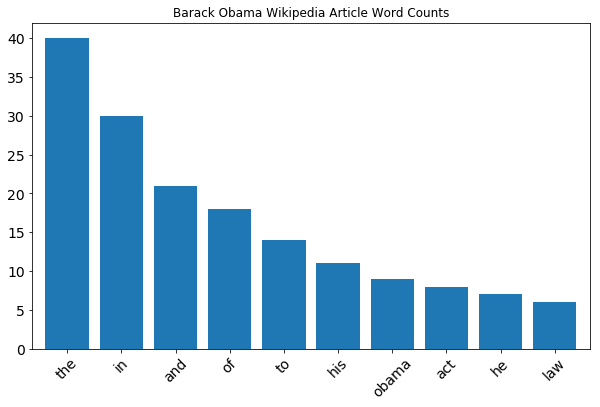

In [42]:
name = 'Barack Obama'
#Extract text for a particular person
text = wiki_data[name]
#Define the count vectorizer that will be used to process the data
count_vectorizer = CountVectorizer()
#Apply this vectorizer to text to get a sparse matrix of counts
count_matrix = count_vectorizer.fit_transform([text])
#Get the names of the features
features = count_vectorizer.get_feature_names()
#Create a series from the sparse matrix
d = pd.Series(count_matrix.toarray().flatten(), index = features).sort_values(ascending=False)

d[:10].plot(kind='bar', title='Barack Obama Wikipedia Article Word Counts',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )


### TF-IDF Vectors
Term frequency-inverse document frequency is a statistic that reflects how important a word is to a specific document relative to all of the words in a collection of documents. The tf-idf value increases proportionally to the number of times that word appears in the document, but is offset by the frequency of the word in the full set of documents (the corpus).

Below, I use a TF-IDF vectorizer to determine the relative importance of the words in the Barack Obama text. Unlike the count vectorizer, this one requires the entire corpus as its input, so it takes a little bit longer to run.

As you can see, the words with the highest TF-IDF values are now a bit more specific to Barack Obama, including words such as "act", "law", and "iraq". 

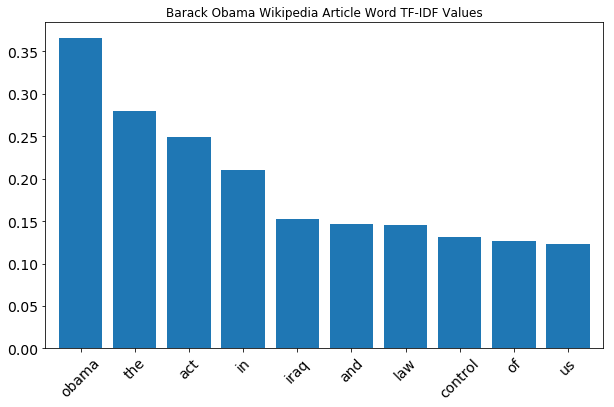

In [43]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer()
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(wiki_data)
#Get the names of the features
features = tfidf_vectorizer.get_feature_names()
#get the row that contains relevant vector
row = wiki_data.index.get_loc(name)
#Create a series from the sparse matrix
d = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(), index = features).sort_values(ascending=False)

d[:10].plot(kind='bar', title='Barack Obama Wikipedia Article Word TF-IDF Values',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )


## Using K-Nearest Neighbors to Identify Similar Articles

Now, we have our TF-IDF matrix, which is a sparse matrix of TF-IDF values with the Wikipedia articles on one axis and the full set of words in the corpus on the other axis. The ```NearestNeighbors``` function can be fit on this sparse matrix and will determine the distance between articles based on their TF-IDF values. I specify that I want to return the 10 nearest neighbors for each article. By default, this function uses Minkowski distance, but  other common distance metrics (Euclidean, Cosine, Manhattan) can be specified as well.

Below I write a function that takes a name as its input and returns the 10 nearest neighbors along with their distances. 

In [76]:
nbrs = NearestNeighbors(n_neighbors=10).fit(tfidf_matrix)

def get_closest_neighs(name):
    row = wiki_data.index.get_loc(name)
    distances, indices = nbrs.kneighbors(tfidf_matrix.getrow(row))
    names_similar = pd.Series(indices.flatten()).map(wiki_data.reset_index()['name'])
    result = pd.DataFrame({'distance':distances.flatten(), 'name':names_similar})
    return result
    

Below, I apply this function to Barack Obama and we see that the nearest neighbors are those that we might expect to see - Joe Biden, Hillary Clinton, etc. 

In [75]:
print get_closest_neighs('Barack Obama')

   distance                     name
0  0.000000             Barack Obama
1  1.067974                Joe Biden
2  1.109491   Hillary Rodham Clinton
3  1.117104           Samantha Power
4  1.139620  Eric Stern (politician)
5  1.147363           George W. Bush
6  1.149957              John McCain
7  1.154632              Artur Davis
8  1.157366             Henry Waxman
9  1.159638            Jeff Sessions


Calculating the nearest neighbors for Taylor Swift returns a set of singers.

In [72]:
print get_closest_neighs('Taylor Swift')

   distance              name
0  0.000000      Taylor Swift
1  1.109846  Carrie Underwood
2  1.129025    Kelly Clarkson
3  1.138605      Dolly Parton
4  1.139351        Joss Stone
5  1.148614        Ed Sheeran
6  1.151302           Rihanna
7  1.153083     JoJo (singer)
8  1.154104   Miranda Lambert
9  1.154456         Amy Grant


And the nearest neighbors for Arnold Schwarzenegger which tend to be a mix of body builders and politicians, which makes sense given Arnold's dual career.

In [73]:
print get_closest_neighs('Arnold Schwarzenegger')

   distance                                    name
0  0.000000                   Arnold Schwarzenegger
1  1.215748                Paul Grant (bodybuilder)
2  1.232618                          Abel Maldonado
3  1.238612                            David Israel
4  1.245451                            James Tramel
5  1.249859                           Russell Gould
6  1.250270                              Gray Davis
7  1.250644                             Jerry Brown
8  1.254132                         Bruce McPherson
9  1.258542  Patrick Johnston (American politician)
